# **Prediction of Genetic Associations in ALS Through NLP and Complex Network Analysis**

This research project aims to predict candidate genes in Amyotrophic Lateral Sclerosis (ALS) using Natural Language Processing (NLP) and complex network analysis techniques.

- **Author:** João Pedro Viguini T. T. Correa  
- **Supervisor:** Prof. Dr. Ricardo Cerri

This research is supported by FAPESP (2025/06512-0)


# Package Installation

- **[IMPORTANT]** Please ensure that all necessary files are downloaded from the GitHub repository and uploaded to your Google Drive.

- The steps below detail the installation process for the required packages and models used in this study.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -r ./drive/MyDrive/IC_2025/requirements.txt

Install spaCy models for NER and tokenization --> It should be inside your Google Drive

In [ ]:
!pip install --upgrade drive/MyDrive/IC_2025/en_ner_bionlp13cg_md-0.5.4.tar.gz --no-deps

# Import


**Restart the session before running this cell.**

In [2]:
import re
import time
import urllib
import numpy as np
import pandas as pd
from Bio import Entrez
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from tqdm import tqdm

try:
    import mygene
    MYGENE_AVAILABLE = True
except Exception:
    print("mygene not available")
    MYGENE_AVAILABLE = False

# Configs

In [3]:
Entrez.email = "ENTREZ_EMAIL" # replace
API_KEY = "ENTREZ_API"   # replace
YEAR_START = 2000
YEAR_END = 2010
MAX_ARTICLES = 100 # how many articles you want to retrieve
SLEEP_TIME = 0.34
MAX_RETRIES = 3
CHUNK_SIZE = 200
VALIDATE_WITH_MYGENE = True
MYGENE_BATCH_SIZE = 1000


base_query = (
    '("amyotrophic lateral sclerosis"[tiab] OR "motor neuron disease"[tiab] OR MND[tiab] OR ALS[tiab]) AND '
    '("gene"[tiab] OR "genes"[tiab] OR genetic[tiab] OR mutation*[tiab] OR polymorphism*[tiab] OR "Genome-Wide Association Study"[Mesh] OR GWAS[tiab])'
)



# Loading NLP models

In [4]:
print("Loading NLP models...")
nlp_ner = None

# spaCy NER
try:
    nlp_ner = spacy.load("en_ner_bionlp13cg_md", disable=["tagger", "parser"])
except Exception as e:
    print("Warning: could not load en_ner_bionlp13cg_md (NER). Error:", e)



Loading NLP models...


/usr/local/lib/python3.12/dist-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


# Preprocessing functions

In [5]:
def clean_text(text):
    if not isinstance(text, str):
        return ""

    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s\-]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text.lower()



GENE_STOPWORDS = set([
    "THE", "AND", "WITH", "FOR", "WAS", "WERE", "ARE", "OUR", "FROM",
    "THIS", "THAT", "THAN", "DISEASE", "PATIENT", "PATIENTS", "GENETIC", "RISK",
    "STUDY", "GENE", "GENES", "ANALYSIS", "RESULT", "RESULTS", "DATA", "MODEL",
    "MODELS", "TYPE", "CASE", "CASES", "ALS", "LATERAL", "SCLEROSIS", "MOTOR",
    "NEURON", "DNA", "RNA", "PROTEIN", "CELL", "CELLS", "TISSUE", "BRAIN",
    "NEURONS", "MOUSE", "MICE",

    "OF", "IN", "TO", "ON", "BY", "AS", "AN", "OR", "IS", "BE", "WE",
    "NOT", "THESE", "HAVE", "HAS", "WITHIN", "FOUND", "US", "INCREASE", "IMPACT"
])


# regex patterns as a fallback
REGEX_PATTERNS = [
    r"\bC\d+ORF\d+\b",           # ex: C9ORF72
    r"\bRS\d{3,9}\b",              # SNP ids: rs123456
    r"\b[A-Z]{2,4}-\d{1,3}\b",    # ex: ABC-1, TDP-43
    r"\b[A-Z]{3,6}[0-9]{0,3}\b"  # ex: SOD1, TP53
]


# Gene extraction using NER

In [6]:
def extract_genes_unbiased(text):
    """
    - Extract gene candidates from a text (NER when available and regex as fallback).

    - Receive the original text (with capital letters/punctuation) to maximize NER retrieval.

    - Return an ordered list of gene-like symbols/tokens in capital letters.
    """

    if not text:
        return []
    text_str = str(text)
    text_upper = text_str.upper()
    genes = set()

    # NER in the original text
    if nlp_ner is not None:
        try:
            doc = nlp_ner(text_str)
            for ent in doc.ents:
                label = getattr(ent, 'label_', '')

                # NER labels (depends on the model)
                if 'GENE' in label.upper() or 'PROTEIN' in label.upper() or 'GENE_PRODUCT' in label.upper():
                    norm = re.sub(r'[^A-Za-z0-9]', '', ent.text)
                    norm_up = norm.upper()
                    if 3 <= len(norm_up) <= 10 and norm_up not in GENE_STOPWORDS: # filter stopwords
                        genes.add(norm_up)
        except Exception:

            # if NER fails, ignore it and continue with regex
            pass


    # regex patterns
    for pattern in REGEX_PATTERNS:
        for match in re.findall(pattern, text_upper):

            # filter stopwords and tokens too short
            if match and match not in GENE_STOPWORDS and len(re.sub(r'[^A-Z0-9]', '', match)) >= 3:
                genes.add(match)


    # removes tokens that are only numbers
    cleaned = set()
    for g in genes:
        if re.search(r'[A-Z]', g):
            cleaned.add(g)
    return sorted(cleaned)


# validation with mygene
def validate_genes_with_mygene(candidate_genes):
    """
    Validates a list of symbols using mygene (batch). Returns a set of validated symbols.

    """
    if not MYGENE_AVAILABLE:
        print("mygene not available; skipping validation.")
        return set()

    mg = mygene.MyGeneInfo()
    validated = set()
    candidates = list(candidate_genes)

    for i in range(0, len(candidates), MYGENE_BATCH_SIZE):
        batch = candidates[i:i+MYGENE_BATCH_SIZE]
        try:
            res = mg.querymany(batch, scopes=['symbol', 'alias', 'name'], fields='symbol,taxid', species='human', entrezonly=False)
            for r in res:
                # r can signal notfound
                if r is None:
                    continue

                if isinstance(r, dict) and not r.get('notfound', False):
                    sym = r.get('symbol')
                    taxid = r.get('taxid')

                    # human (taxid 9606) or None (some results doesn't have taxid)
                    if sym and (taxid is None or int(taxid) == 9606):
                        validated.add(sym.upper())
        except Exception as e:
            print(f"mygene query batch failed: {e}")

            # in case of error, we just continue
            continue

    return validated


# Pubmed article collection

In [7]:
def safe_read_abstract(article):

    """
    Extracts pubmed abstracts with tolerance to different formats
    """

    try:
        art = article['MedlineCitation']['Article']
        abstract_field = art.get('Abstract')
        if not abstract_field:
            return ''
        abstract_text = abstract_field.get('AbstractText')
        if not abstract_text:
            return ''

        # abstractText can be a list of string or a list of dicts (with #text)
        abstract_parts = []
        for a in abstract_text:
            if isinstance(a, dict):

                # some XMLs have {'Label': 'BACKGROUND', 'NlmCategory': '...','#text': '...'}
                txt = a.get('#text') or a.get('label') or a.get('Label') or ''
                abstract_parts.append(str(txt))
            else:
                abstract_parts.append(str(a))
        return ' '.join([p for p in abstract_parts if p])
    except Exception:
        return ''


def get_genetic_als_articles():

    """
      Search for pubmed articles based on the query
    """

    encoded_query = base_query
    articles = []

    try:
        handle = Entrez.esearch(
            db="pubmed",
            term=encoded_query,
            retmax=0,
            mindate=str(YEAR_START),
            maxdate=str(YEAR_END),
            datetype="pdat",
            api_key=API_KEY
        )

        result = Entrez.read(handle)
        handle.close()
        total = int(result.get("Count", 0))

        print(f"Found {total} genetic ALS articles")

        if total == 0:
            return pd.DataFrame()


        for retry in range(MAX_RETRIES):
            try:
                handle = Entrez.esearch(
                    db="pubmed",
                    term=encoded_query,
                    retmax=MAX_ARTICLES,
                    mindate=str(YEAR_START),
                    maxdate=str(YEAR_END),
                    datetype="pdat",
                    usehistory="y",
                    api_key=API_KEY
                )
                search_result = Entrez.read(handle)
                handle.close()
                id_list = search_result.get("IdList", [])

                # Fetch details em batches
                for i in tqdm(range(0, min(len(id_list), MAX_ARTICLES), CHUNK_SIZE)):
                    batch = id_list[i:i+CHUNK_SIZE]
                    fetch_handle = Entrez.efetch(
                        db="pubmed",
                        id=batch,
                        retmode="xml",
                        api_key=API_KEY
                    )
                    try:
                        data = Entrez.read(fetch_handle)
                    except Exception:

                        data = {}
                    finally:
                        fetch_handle.close()

                    for article in data.get('PubmedArticle', []):
                        try:
                            title = article['MedlineCitation']['Article'].get('ArticleTitle', '')
                            abstract = safe_read_abstract(article)
                            pmid = str(article['MedlineCitation']['PMID'])
                            text = f"{title} {abstract}".strip()


                            articles.append({
                                "pmid": pmid,
                                "title": title,
                                "abstract": abstract,
                                "text": text
                            })
                        except KeyError:
                            continue
                    time.sleep(SLEEP_TIME)
                break
            except Exception as e:
                print(f"Attempt {retry + 1} failed: {str(e)}")
                time.sleep(2 ** retry)
    except Exception as e:
        print(f"Fatal error in PubMed query: {str(e)}")
    return pd.DataFrame(articles)


# Useful functions

- For training models and calculating the ranking

In [ ]:
!pip install --upgrade torch torchvision torchaudio # these are for using BioBERT
!pip install --upgrade --force-reinstall transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 6.1 MB/s eta 0:00:00
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.4 MB/s eta 0:00:00
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached typing_extensions-4.14.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached charset_normalizer-3.4.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (36 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.8.3-py3-none-any.whl.metadata (2.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 110

In [59]:
import os
import fasttext
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from collections import defaultdict

def get_mean_embedding(texts, tokenizer, model, device):

    """calculates mean embedding for genes using BioBERT """

    # tokenize input texts (genes) and prepare for model
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    special_ids = set(tokenizer.all_special_ids) # CLS and SEP

    with torch.no_grad():
        # get model outputs and extract embeddings
        outputs = model(**inputs)
        token_embeddings = outputs.last_hidden_state

        # create mask to exclude special tokens
        special_mask = torch.ones_like(attention_mask)

        for sid in special_ids:
            special_mask = special_mask & (input_ids != sid)
        valid_mask = attention_mask.long() & special_mask.long()

        # calculate mean pooling of valid tokens
        mask_expanded = valid_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        summed = torch.sum(token_embeddings * mask_expanded, 1)
        counts = mask_expanded.sum(1).clamp(min=1)
        mean_pooled = summed / counts

    return mean_pooled.cpu().numpy()

def get_embeddings(gene_list, model, model_type):

    """
      gets embeddings for gene list depending on the model
    """

    # convert genes to lowercase for embedding lookup
    lowercase_genes = [g.lower() for g in gene_list]

    if model_type == 'fasttext':
        # filter genes that exist in fasttext vocabulary
        valid_genes = [g for g in lowercase_genes if model.get_word_id(g) != -1]
        embeddings = np.array([model.get_word_vector(g) for g in valid_genes])

        # return original case genes with their embeddings
        original_case_genes = [gene_list[i] for i, g in enumerate(lowercase_genes) if g in valid_genes]
        return embeddings, original_case_genes

    elif model_type == 'biobert':
        # get biobert embeddings for lowercase gene names
        tokenizer = model['tokenizer']
        biobert_model = model['model']
        device = model.get('device', 'cpu')
        embeddings = get_mean_embedding(lowercase_genes, tokenizer, biobert_model, device)

        return embeddings, gene_list  # returns original case
    else:
        raise ValueError(f"Unsupported model type: {model_type}")


def calculate_gene_scores(df):
    """
      calculates TF-IDF scores for genes in the dataframe

    """

    # check for empty dataframe or missing columns
    if df.empty or 'genes' not in df.columns or 'clean_text' not in df.columns:
        return []

    # get unique uppercase genes for final output
    uppercase_genes = sorted({gene.upper() for genes_list in df['genes'] for gene in genes_list})

    if not uppercase_genes:
        return []

    # lowercase version for vectorizer matching
    lowercase_vocab = [gene.lower() for gene in uppercase_genes]

    # get cleaned text documents
    docs = df['clean_text'].tolist()

    # initialize TF-IDF vectorizer with lowercase vocabulary
    vectorizer = TfidfVectorizer(
        vocabulary=lowercase_vocab,
        lowercase=False,  # already lowercase
        token_pattern=r"(?u)\b\w+\b"
    )

    # calculate TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform(docs)

    # sum scores across all documents
    scores = np.asarray(tfidf_matrix.sum(axis=0)).ravel()

    # combine genes with scores and sort
    gene_scores = sorted(zip(uppercase_genes, scores), key=lambda x: x[1], reverse=True)

    return gene_scores


def calculate_combined_ranking(gene_score_dict, model, model_type: str, alpha=0.5, known_als_genes=None):

    """
      - Combines TF-IDF and semantic similarity scores for final ranking
      - Currently we are only using the semantic similarity as the final score.
          - To test a combined score, change the return to use 'combined' instead of 'sim_raw'
    """

    # default known ALS genes if none provided
    if known_als_genes is None:
        known_als_genes = {
            "ANXA11", "C9ORF72", "CHCHD10", "EPHA4", "FUS", "HNRNPA1", "KIF5A", "NEK1",
            "OPTN", "PFN1", "SOD1", "TARDBP", "TDP-43", "TDP43", "TBK1", "UBQLN2",
            "UNC13A", "VAPB", "VCP"
        }

    known_als_genes = {g.upper() for g in known_als_genes}

    # get embeddings for known ALS genes
    known_embeddings, valid_known_genes = get_embeddings(
        list(known_als_genes), model, model_type
    )

    if len(valid_known_genes) == 0:
        print("No known genes found in model.")
        return pd.DataFrame()

    known_embeddings = normalize(known_embeddings, axis=1) # normalize it

    # get embeddings for candidate genes
    candidates = [gene.upper() for gene in gene_score_dict]
    candidate_embeddings, valid_candidates = get_embeddings(
        candidates, model, model_type
    )

    if len(valid_candidates) == 0:
        print("No candidate embeddings generated.")
        return pd.DataFrame()

    candidate_embeddings = normalize(candidate_embeddings, axis=1) # normalize it

    # cosine similarity between candidates and known genes
    similarity_matrix = cosine_similarity(candidate_embeddings, known_embeddings)
    max_similarities = np.max(similarity_matrix, axis=1) # take the MAX score

    # create results dataframe with combined scores
    results_df = pd.DataFrame({
        'gene': [g.upper() for g in valid_candidates],
        'tfidf_raw': [gene_score_dict[g.upper()] for g in valid_candidates],
        'sim_raw': max_similarities
    })


    # normalize scores before combining them with alpha (just testing)
    for col in ['tfidf_raw', 'sim_raw']:
        min_val, max_val = results_df[col].min(), results_df[col].max()

        results_df[f'{col}_norm'] = (results_df[col] - min_val) / (max_val - min_val + 1e-9)


    results_df['combined'] = alpha * results_df['tfidf_raw_norm'] + (1 - alpha) * results_df['sim_raw_norm']

    # change for 'combined' if you want the combined score w/ TF-IDF; we're currently using only the semantic similarity.
    return results_df.sort_values('sim_raw', ascending=False)

# Helpful functions

In [60]:

# txt for fasttext
def save_corpus_for_fasttext(df, filepath="fasttext_corpus.txt"):
    with open(filepath, "w", encoding="utf-8") as f:
        for text in df['clean_text']:
            f.write(text + "\n")

    print(f"Corpus saved to {filepath}")


# train or load fastText model
def get_fasttext_model(corpus_path="fasttext_corpus.txt", model_path=f"fasttext_model_{YEAR_END}.bin", force_retrain=False):

    if not force_retrain and os.path.exists(model_path):
        print(f"Loading pre-trained model from {model_path}")
        return fasttext.load_model(model_path)

    print("Training new FastText model...")
    model = fasttext.train_unsupervised(
        corpus_path,
        model='skipgram',
        dim=300,
        epoch=10,
        minn=3,
        maxn=6,
        ws=10,
        lr=0.05,
        minCount=2,
        thread=4)

    model.save_model(model_path)
    print(f"Model saved to {model_path}")

    return model


# Metrics

In [54]:

# precision at k - fraction of relevant items in top k results
def calculate_precision_at_k(ranked_list, validation_set, k):
    top_k = ranked_list[:k]
    hits = len(set(top_k) & validation_set)

    return hits / k if k > 0 else 0

# recall at k - fraction of relevant items found in top k
def calculate_recall_at_k(ranked_list, validation_set, k):

    top_k = ranked_list[:k]
    hits = len(set(top_k) & validation_set)

    return hits / len(validation_set) if len(validation_set) > 0 else 0

# mean reciprocal rank of first relevant item
def calculate_mrr(ranked_list, validation_set):

    for i, item in enumerate(ranked_list):
        if item in validation_set:
            return 1 / (i + 1)
    return 0.0

# Preparing fine-tuning BioBERT

In [22]:
import pandas as pd

# preparing corpus for fine-tuning BioBERT
try:
    df = pd.read_csv(f'als_articles_with_genes_{YEAR_END}.csv')

    # Get the clean_text column and drop any empty rows
    texts = df['clean_text'].dropna().tolist()

    # Save the texts into a file, one abstract/text per line
    with open('als_corpus_for_finetuning.txt', 'w', encoding='utf-8') as f:
        for text in texts:
            f.write(text + '\n')

    print("File 'als_corpus_for_finetuning.txt' created successfully.")

except FileNotFoundError:
    print("Error: 'als_articles_with_genes.csv' not found. Please run the main data collection pipeline first (after the fine-tuning cell below).")

File 'als_corpus_for_finetuning.txt' created successfully.


In [ ]:
#!pip install datasets -q

import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)

SAVE_PATH = "./drive/MyDrive/IC_2025/biobert-finetuned-als_2010"

# loading the corpus
try:
    raw_datasets = load_dataset('text', data_files={'train': 'als_corpus_for_finetuning.txt'})
    print("Corpus loaded successfully.")
except Exception as e:
    print(f"Failed to load corpus file. Error: {e}")


# loading pre-trained model and tokenizer
model_checkpoint = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# AutoModelForMaskedLM because this is the architecture needed for MLM fine-tuning
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

# tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding='max_length', max_length=512)

tokenized_datasets = raw_datasets.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]
)


# create batches and mask 15% of the tokens for training.
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

# training arguments
training_args = TrainingArguments(
    output_dir=SAVE_PATH, # directory to save the new model
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    save_steps=10_000,
    save_total_limit=2,                # only keep the last 2 checkpoints
    prediction_loss_only=True,
    report_to="none"
)

# initialize and run the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
)

print("\nStarting the BioBERT fine-tuning process on the ALS corpus...")
trainer.train()
print("Fine-tuning complete!")

# saving the model
trainer.save_model(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH) #  save the tokenizer
print(f"Fine-tuned model saved to the directory {SAVE_PATH}.")

Generating train split: 0 examples [00:00, ? examples/s]

Corpus loaded successfully.


Map:   0%|          | 0/2651 [00:00<?, ? examples/s]


Starting the BioBERT fine-tuning process on the ALS corpus...


Step,Training Loss
500,2.684200


Fine-tuning complete!
Fine-tuned model saved to the directory ./drive/MyDrive/IC_2025/biobert-finetuned-als_2010.


# Main

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import average_precision_score, ndcg_score
from collections import defaultdict
import os
import torch
from transformers import AutoTokenizer, AutoModel

MODEL_CHOICE = 'fasttext' # choose your model: 'fasttext' or 'biobert'

MODEL_MAP = {'biobert': 'dmis-lab/biobert-base-cased-v1.1'} # we may include more models in this dict

VALIDATION_GENES = {
    "ANXA11", "C9ORF72", "CHCHD10", "EPHA4", "FUS", "HNRNPA1", "KIF5A", "NEK1",
    "OPTN", "PFN1", "SOD1", "TARDBP", "TDP-43", "TDP43", "TBK1", "UBQLN2",
    "UNC13A", "VAPB", "VCP"
}
VALIDATION_GENES = {g.upper() for g in VALIDATION_GENES}


if __name__ == "__main__":

    print("Starting pipeline...\n")

    # data loading and processing
    csv_path = f"als_articles_with_genes_{YEAR_END}.csv"
    df = pd.DataFrame()

    if os.path.exists(csv_path):
        try:
            df = pd.read_csv(csv_path)
            if not df.empty and isinstance(df['genes'].iloc[0], str):
                 df['genes'] = df['genes'].apply(lambda x: eval(x))
            print(f"Existing data loaded from {csv_path} ({len(df)} articles).")
        except (pd.errors.EmptyDataError, pd.errors.ParserError):
            df = get_genetic_als_articles()
    else:
        df = get_genetic_als_articles()


    # extracting and validating genes
    if not df.empty:
        if 'clean_text' not in df.columns:
            df['text'] = df['text'].fillna('')
            df['clean_text'] = df['text'].apply(clean_text)
        if 'genes' not in df.columns:
            df['genes'] = df['text'].apply(extract_genes_unbiased)

            if VALIDATION_GENES and MYGENE_AVAILABLE:
                valid_genes = validate_genes_with_mygene(set(g for gl in df['genes'] for g in gl))
                df['genes'] = df['genes'].apply(lambda genes: [g for g in genes if g in valid_genes])
        df.to_csv(csv_path, index=False)

        print(f"Processed data saved to '{csv_path}'.")


        print("\nCalculating TF-IDF scores...")
        gene_scores = calculate_gene_scores(df)

        # loading/training the model
        embedding_model = None

        if MODEL_CHOICE == 'biobert':
            print("Initializing BioBERT...")

            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            finetuned_model_path = "./drive/MyDrive/IC_2025/biobert-finetuned-als_2010"


            tokenizer = AutoTokenizer.from_pretrained(finetuned_model_path)
            model = AutoModel.from_pretrained(finetuned_model_path).to(device)
            embedding_model = {'tokenizer': tokenizer, 'model': model, 'device': device}


        elif MODEL_CHOICE == 'fasttext':
            print("Initializing fastText...")

            corpus_filepath = "fasttext_corpus.txt"
            model_filepath = f"./drive/MyDrive/IC_2025/fasttext_model_{YEAR_END}.bin"

            if not os.path.exists(corpus_filepath):
                save_corpus_for_fasttext(df, filepath=corpus_filepath)

            embedding_model = get_fasttext_model(corpus_path=corpus_filepath, model_path=model_filepath)


        # ranking
        if embedding_model:
            gene_score_dict = {gene.upper(): score for gene, score in gene_scores}

            ranked_genes_full = calculate_combined_ranking(
                gene_score_dict,
                model=embedding_model,
                model_type=MODEL_CHOICE,
                alpha=0.5,    # 0.4 == 40% TF-IDF, 60% similarity --> test new values.
                known_als_genes=VALIDATION_GENES
            )

            # metrics calculation (on list with known genes)
            print("\nCalculating performance metrics...")

            y_true = ranked_genes_full['gene'].str.upper().apply(lambda x: 1 if x in VALIDATION_GENES else 0).values
            y_score = ranked_genes_full['combined'].values
            ranked_list_full = ranked_genes_full['gene'].str.upper().tolist()

            metrics = {
                'P@10': calculate_precision_at_k(ranked_list_full, VALIDATION_GENES, 10),
                'P@20': calculate_precision_at_k(ranked_list_full, VALIDATION_GENES, 20),
                'R@50': calculate_recall_at_k(ranked_list_full, VALIDATION_GENES, 50),
                'MAP': average_precision_score(y_true, y_score),
                'nDCG': ndcg_score([y_true], [y_score]),
                'MRR': calculate_mrr(ranked_list_full, VALIDATION_GENES)
            }
            metrics_df = pd.DataFrame([metrics], index=[MODEL_CHOICE.capitalize()])

            # filtering for novel candidates
            ranked_novel_genes = ranked_genes_full[~ranked_genes_full['gene'].isin(VALIDATION_GENES)]



            # to make temporal analysis --> use ranked_genes_full
            # to discover new candidate genes --> use ranked_novel_genes

            if not ranked_novel_genes.empty:
                print(f"\n--- TOP 20 NOVEL CANDIDATES (Model: {MODEL_CHOICE.upper()}) ---")
                for i, row in enumerate(ranked_novel_genes.head(20).itertuples(), 1):
                    print(f"{i}. {row.gene.upper():<10} | Score: {row.combined:.4f} (TF-IDF: {row.tfidf_raw_norm:.4f}, Sim: {row.sim_raw_norm:.4f})")

                output_filename = f'als_novel_gene_candidates_{MODEL_CHOICE}.csv'
                ranked_novel_genes.to_csv(output_filename, index=False)
                print(f"\nResults with novel genes saved to '{output_filename}'")

            print("\n--- Performance Metrics Table ---")
            print(metrics_df.round(4))

In [ ]:
df["genes"]

# Temporal validation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt


GENE_TO_QUERY = "KIF5A"
MODEL_TO_USE = 'fasttext'

VALIDATION_GENES = {
    "ANXA11", "C9ORF72", "CHCHD10", "EPHA4", "FUS", "HNRNPA1", "KIF5A", "NEK1",
    "OPTN", "PFN1", "SOD1", "TARDBP", "TBK1", "UBQLN2",
    "UNC13A", "VAPB", "VCP"
}
VALIDATION_GENES = {g.upper() for g in VALIDATION_GENES}


print(f"Loading the model... '{MODEL_TO_USE}'...")
embedding_model = None

if MODEL_TO_USE == 'biobert':
    FINETUNED_MODEL_PATH = "./drive/MyDrive/IC_2025/biobert-finetuned-als_2010"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    tokenizer = AutoTokenizer.from_pretrained(FINETUNED_MODEL_PATH)
    model = AutoModel.from_pretrained(FINETUNED_MODEL_PATH).to(device)
    embedding_model = {'tokenizer': tokenizer, 'model': model, 'device': device}

elif MODEL_TO_USE == 'fasttext':
    model_filepath = f"./drive/MyDrive/IC_2025/fasttext_model_{YEAR_END}.bin"
    embedding_model = fasttext.load_model(model_filepath)

df_full = pd.read_csv('als_articles_with_genes_2010.csv')
df_full['genes'] = df_full['genes'].apply(lambda x: eval(x))
all_genes_in_corpus = set(g.upper() for gene_list in df_full['genes'] for g in gene_list)



def find_similar_genes_within_set(input_gene, model, model_type, comparison_set):

    print(f"\nCalculating similarity of '{input_gene.upper()}' with reference set...")
    input_gene_upper = input_gene.upper()
    comparison_set_upper = {g.upper() for g in comparison_set}
    comparison_set_upper.discard(input_gene_upper)
    genes_to_embed = [input_gene_upper] + list(comparison_set_upper)
    all_embeddings, valid_genes_list = get_embeddings(genes_to_embed, model, model_type)

    if input_gene_upper not in valid_genes_list:
        print(f"ERROR: Candidate gene '{input_gene_upper}' was not found in the model's vocabulary.")
        return None

    all_embeddings = normalize(all_embeddings)
    input_embedding = all_embeddings[0].reshape(1, -1)
    comparison_embeddings = all_embeddings[1:]
    comparison_genes = valid_genes_list[1:]
    similarities = cosine_similarity(input_embedding, comparison_embeddings)
    results = sorted(zip(comparison_genes, similarities[0]), key=lambda item: item[1], reverse=True)
    print(f"\n--- Similarity ranking with '{input_gene_upper}' (Model: {model_type.capitalize()}) ---")
    for gene, score in results:
        print(f"{gene:<12} | Similarity: {score:.4f}")
    return results


if embedding_model:
    if GENE_TO_QUERY.upper() in all_genes_in_corpus:

        # reference set should be both in validation genes and in model's vocab
        final_comparison_set = VALIDATION_GENES.intersection(all_genes_in_corpus)

        print(f"\nIniciando análise. Comparando com {len(final_comparison_set)} genes validados que estão presentes no corpus.")

        similarity_results = find_similar_genes_within_set(GENE_TO_QUERY, embedding_model, MODEL_TO_USE, final_comparison_set)


        if similarity_results:

            top_10_results = similarity_results[:10]
            df_plot = pd.DataFrame(top_10_results, columns=['gene', 'similarity'])
            df_plot = df_plot.sort_values('similarity', ascending=True)
            plt.style.use('seaborn-v0_8-whitegrid')
            plt.figure(figsize=(10, 7), dpi=120)
            plt.barh(df_plot['gene'], df_plot['similarity'], color='skyblue', edgecolor='black')
            plt.xlabel('Cosine Similarity', fontsize=12)
            plt.title(f'Top Most Similar ALS Genes to "{GENE_TO_QUERY.upper()}"', fontsize=16, weight='bold')
            plt.grid(axis='x', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.savefig(f'similarity_plot_{GENE_TO_QUERY.upper()}.png', dpi=300)
            plt.show()

    else:
        print(f"\nERROR: Gene '{GENE_TO_QUERY.upper()}' not found on the list of genes of the corpus..")
else:
    print(f"Model '{MODEL_TO_USE}' could not be loaded.")

# Plotting the results

Loaded data from 'als_novel_gene_candidates_fasttext.csv'
Figure saved as 'separate_scores_visualization_fasttext.png'


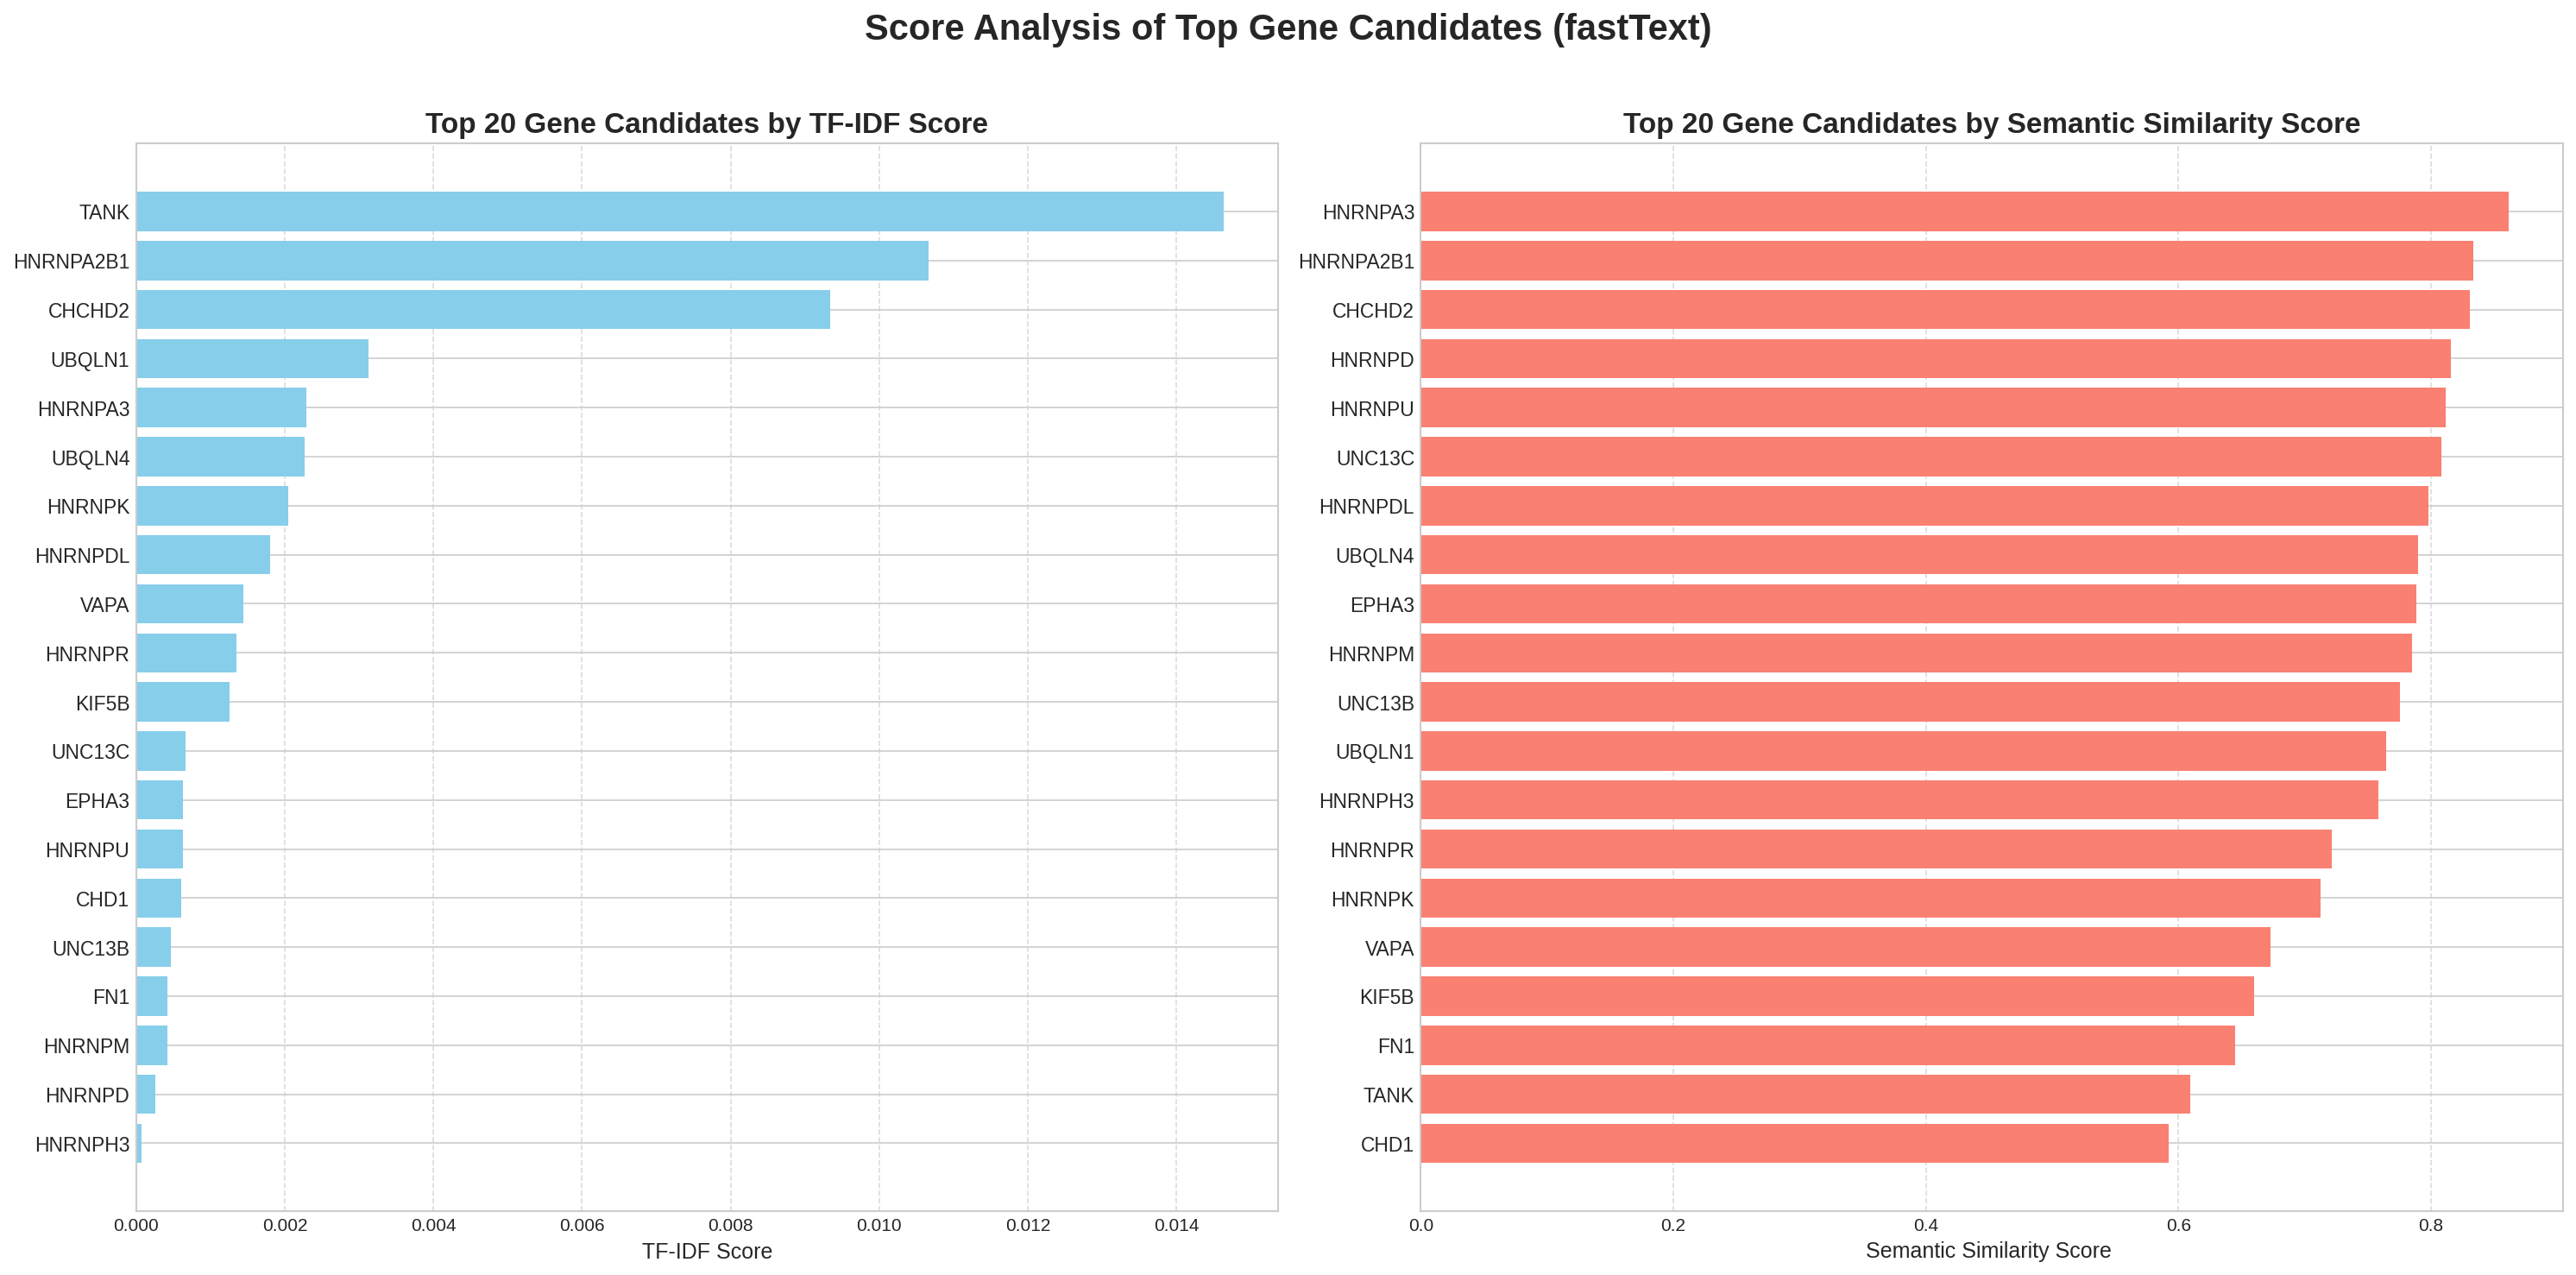

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



def plot_separate_score_charts(model_choice: str, num_genes: int = 20):
    """
      Loads model results and generates two separate bar charts for the TF-IDF
      and Semantic Similarity scores of the top N candidate genes.

    """

    # loads data
    results_filename = f'als_novel_gene_candidates_{model_choice}.csv'
    try:
        ranked_genes_df = pd.read_csv(results_filename)
        print(f"Loaded data from '{results_filename}'")
    except FileNotFoundError:
        print(f"Error: The results file '{results_filename}' was not found.")
        print("Please run the main pipeline cell first to generate the results.")
        return

    # select the top N genes based on the overall combined score
    top_genes = ranked_genes_df.head(num_genes)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(
        1, 2,  # 1 row, 2 columns
        figsize=(20, 10),
        dpi=150
    )


    # sort data by TF-IDF score for this plot
    tfidf_sorted = top_genes.sort_values('tfidf_raw_norm', ascending=True)

    axes[0].barh(
        tfidf_sorted['gene'].str.upper(),
        tfidf_sorted['tfidf_raw_norm'],
        color='skyblue'
    )
    axes[0].set_title('Top 20 Gene Candidates by TF-IDF Score', fontsize=16, weight='bold')
    axes[0].set_xlabel('TF-IDF Score', fontsize=12)
    axes[0].tick_params(axis='y', labelsize=11)
    axes[0].grid(axis='x', linestyle='--', alpha=0.7)



    # sort data by similarity score for this plot
    sim_sorted = top_genes.sort_values('sim_raw_norm', ascending=True)

    axes[1].barh(
        sim_sorted['gene'].str.upper(),
        sim_sorted['sim_raw_norm'],
        color='salmon'
    )
    axes[1].set_title('Top 20 Gene Candidates by Semantic Similarity Score', fontsize=16, weight='bold')
    axes[1].set_xlabel('Semantic Similarity Score ', fontsize=12)
    axes[1].tick_params(axis='y', labelsize=11) # Adjust y-axis label size
    axes[1].grid(axis='x', linestyle='--', alpha=0.7)


    fig.suptitle(
        f'Score Analysis of Top Gene Candidates (fastText)',
        fontsize=20,
        weight='bold'
    )

    # adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # saving figure
    output_fig_filename = f'separate_scores_visualization_{model_choice}.png'
    plt.savefig(output_fig_filename, dpi=300)
    print(f"Figure saved as '{output_fig_filename}'")
    plt.show()



model_to_visualize = 'fasttext' # 'fasttext', 'biobert'

plot_separate_score_charts(model_choice=model_to_visualize)

# Network Analysis

In [ ]:
!pip install networkx python-louvain -q

Loading data and generating embeddings for all genes...


Some weights of BertModel were not initialized from the model checkpoint at ./drive/MyDrive/IC_2025/biobert-finetuned-als and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Generated embeddings for 2527 unique genes.

Creating similarity network with threshold: 0.9...
Initial network: 2527 nodes and 11760 edges.
Filtered network (no isolates): 1927 nodes and 11760 edges.

--- Network Analysis Results ---
Average Clustering Coefficient: 0.4405

Top 10 Genes by Betweenness Centrality:
- DCP1B: 0.0324
- TAX1BP1: 0.0183
- KCNB2: 0.0170
- MAP1LC3B: 0.0170
- RAB3GAP1: 0.0169
- SF3B1: 0.0168
- RAB3GAP2: 0.0167
- TBC1D1: 0.0164
- MAP1B: 0.0159
- TPCN1: 0.0158

Detecting community structure with Louvain algorithm...
Number of communities detected: 127
Modularity Score: 0.6132

Genes in the largest communities:

Community 5 (232 genes):
CACNB1, CNBP, KCNB2, RBCK1, DBN1, DBR1, KCND2, BACE1, CALB1, MBL2, MBNL1, TBL1X, UBR1, FBLN1, BECN1...

Community 2 (217 genes):
ABCA1, ABCA4, ABCA7, ABCB1, ABCC1, ABCC10, ABCC2, ABCC6, ABCC8, ABCC9, ABCD1, ABCD2, ABCD3, ABCE1, ABCG1...

Community 6 (174 genes):
CDCP1, DCDC2, DDB1, HDAC1, PRKCD, VDAC1, YTHDC1, HDAC2, KDM2B, UBTD2, H

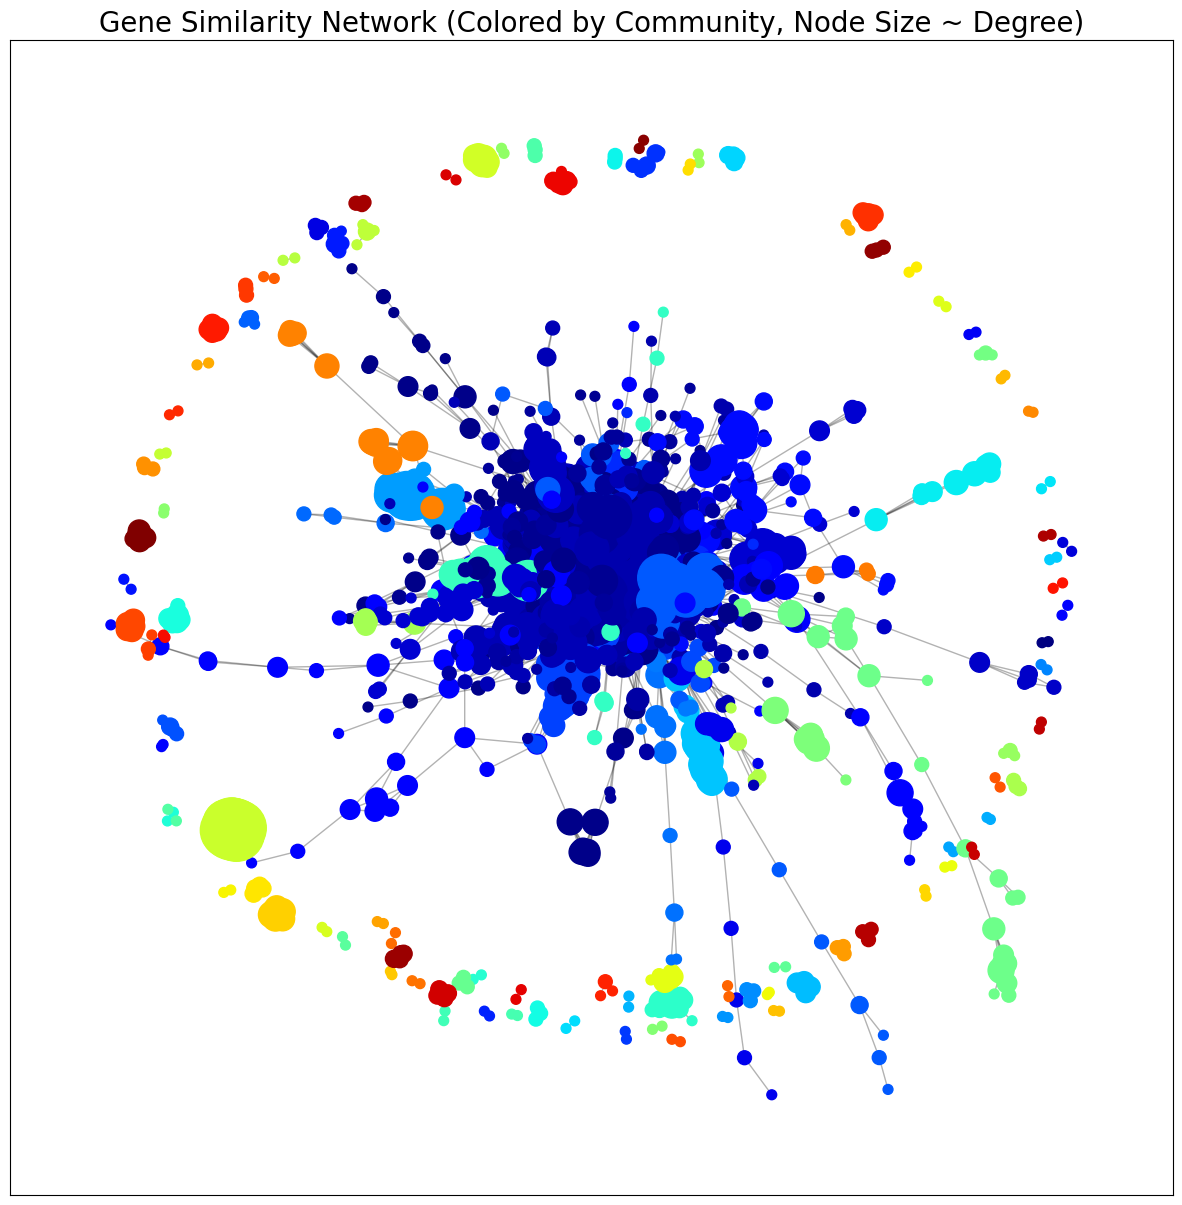


Plotting top communities...


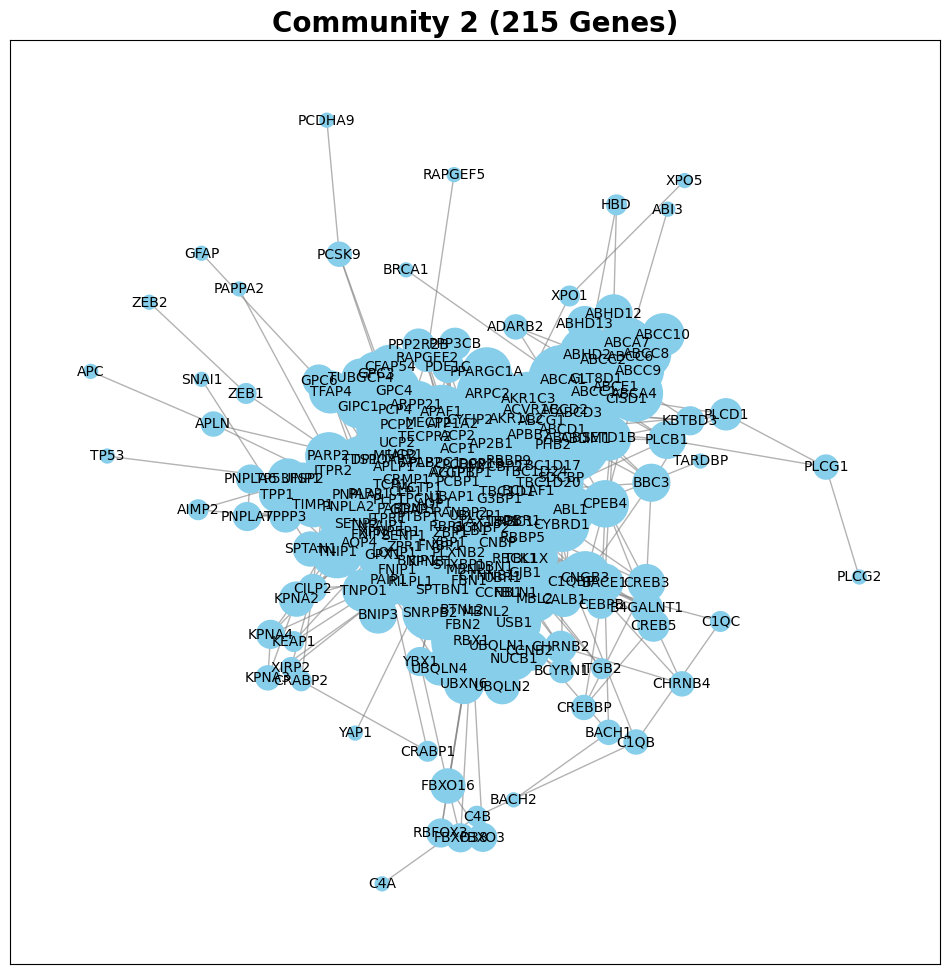

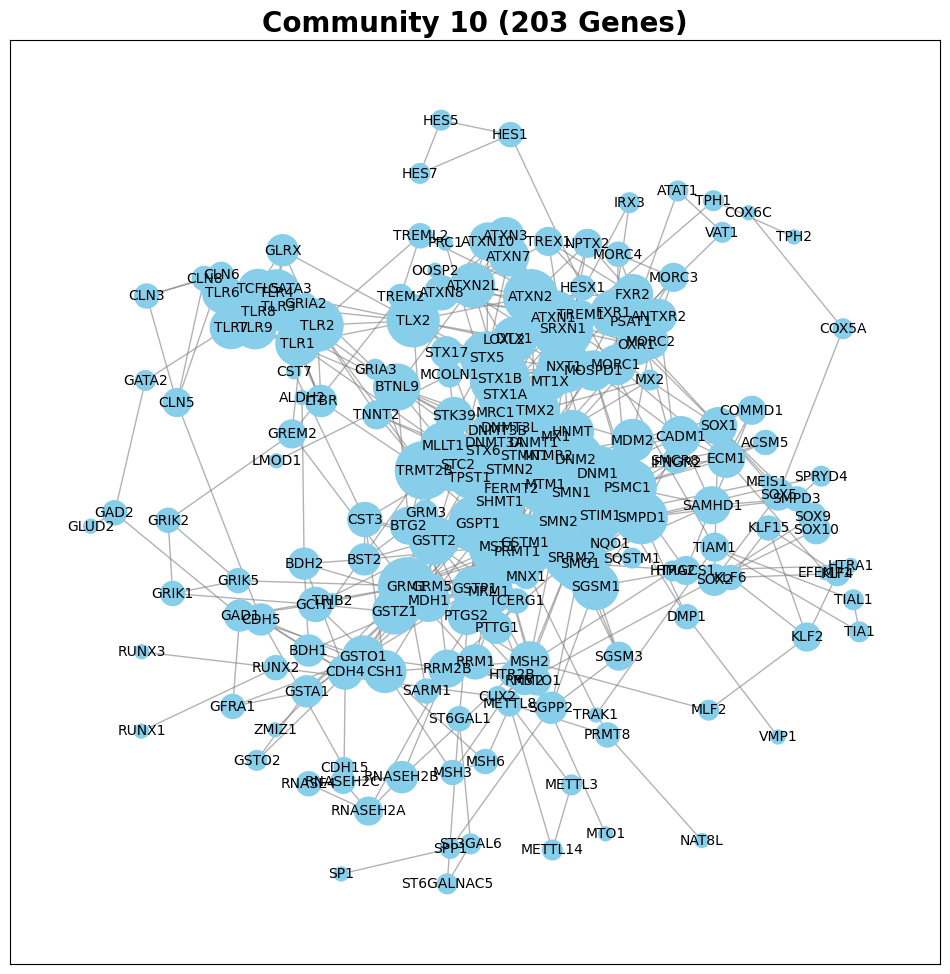

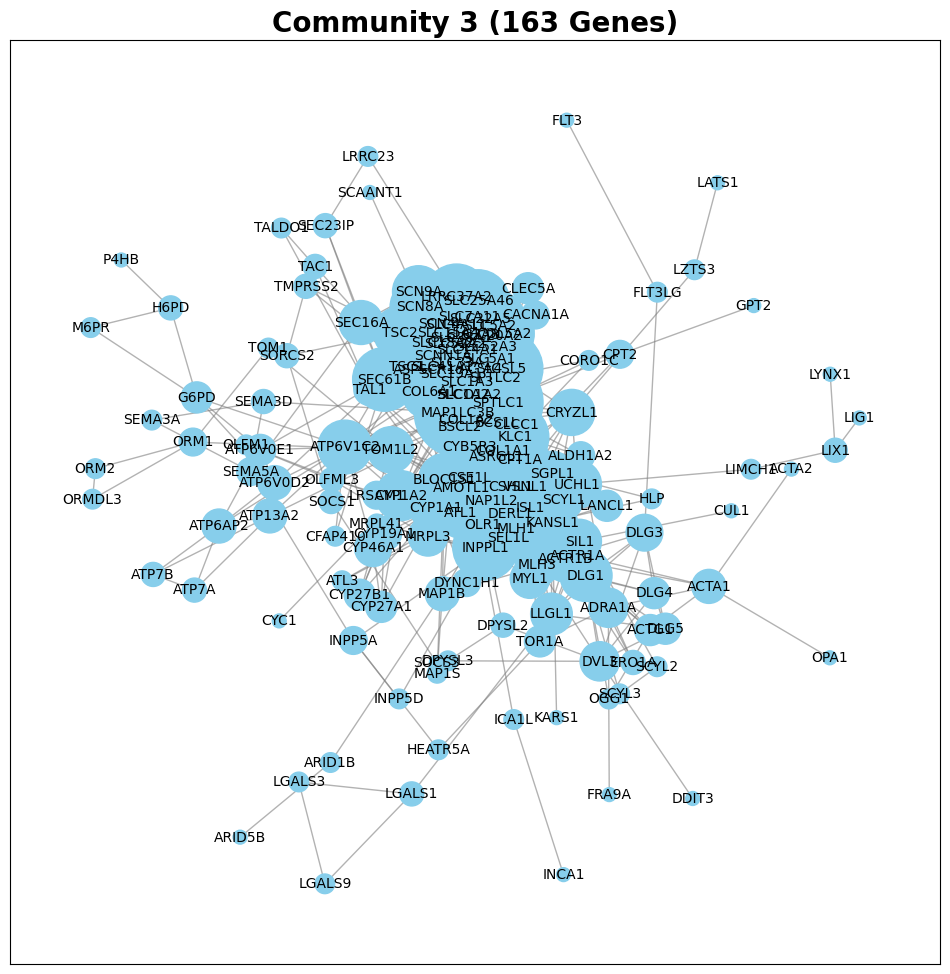

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import torch
from transformers import AutoTokenizer, AutoModel


FINETUNED_MODEL_PATH = "./drive/MyDrive/IC_2025/biobert-finetuned-als"
SIMILARITY_THRESHOLD = 0.9  # similarity threshold


# loading and generating embeddings
print("Loading data and generating embeddings for all genes...")

df_full = pd.read_csv('als_articles_with_genes.csv')
df_full['genes'] = df_full['genes'].apply(lambda x: eval(x))

all_genes_in_corpus = sorted(list(set(g.upper() for gene_list in df_full['genes'] for g in gene_list)))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = AutoTokenizer.from_pretrained(FINETUNED_MODEL_PATH)
model = AutoModel.from_pretrained(FINETUNED_MODEL_PATH).to(device)
model_components = {'tokenizer': tokenizer, 'model': model, 'device': device}

# getting embeddings
all_embeddings, all_genes_list = get_embeddings(all_genes_in_corpus, model_components, 'biobert')
all_embeddings = normalize(all_embeddings)

print(f"Generated embeddings for {len(all_genes_list)} unique genes.")


# creating the network
print(f"\nCreating similarity network with threshold: {SIMILARITY_THRESHOLD}...")

similarity_matrix = cosine_similarity(all_embeddings)

G = nx.Graph()
for i in range(len(all_genes_list)):
    G.add_node(all_genes_list[i])
    for j in range(i + 1, len(all_genes_list)):
        if similarity_matrix[i, j] > SIMILARITY_THRESHOLD:
            G.add_edge(all_genes_list[i], all_genes_list[j], weight=similarity_matrix[i, j])

print(f"Initial network: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# removing isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))
print(f"Filtered network (no isolates): {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


# network metrics
print("\n--- Network Analysis Results ---")

avg_clustering = nx.average_clustering(G)
print(f"Average Clustering Coefficient: {avg_clustering:.4f}")

print("\nTop 10 Genes by Betweenness Centrality:")
betweenness = nx.betweenness_centrality(G)
sorted_betweenness = sorted(betweenness.items(), key=lambda item: item[1], reverse=True)
for gene, score in sorted_betweenness[:10]:
    print(f"- {gene}: {score:.4f}")

print("\nDetecting community structure with Louvain algorithm...")
partition = community_louvain.best_partition(G)
modularity = community_louvain.modularity(partition, G)
num_communities = len(set(partition.values()))

print(f"Number of communities detected: {num_communities}")
print(f"Modularity Score: {modularity:.4f}")

print("\nGenes in the largest communities:")
community_sizes = pd.Series(partition).value_counts()
for i in range(min(5, num_communities)):
    community_id = community_sizes.index[i]
    community_genes = [node for node, com in partition.items() if com == community_id]
    print(f"\nCommunity {community_id} ({len(community_genes)} genes):")
    print(", ".join(community_genes[:15]) + ('...' if len(community_genes) > 15 else ''))


# full network
print("\nGenerating network visualization...")
plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G, seed=42)

colors = [partition[node] for node in G.nodes()]
degrees = dict(G.degree())
node_sizes = [degrees[node] * 50 for node in G.nodes()]  # size is proportional to degree

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=colors, cmap=plt.cm.jet)
nx.draw_networkx_edges(G, pos, alpha=0.3)

plt.title("Gene Similarity Network (Colored by Community, Node Size ~ Degree)", fontsize=20)
plt.show()


# plot top communities
print("\nPlotting top communities...")

partition = community_louvain.best_partition(G)
community_sizes = pd.Series(partition).value_counts()
num_top_communities_to_plot = 3

for i in range(min(num_top_communities_to_plot, len(community_sizes))):
    community_id = community_sizes.index[i]
    community_nodes = [node for node, com in partition.items() if com == community_id]
    community_graph = G.subgraph(community_nodes)

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(community_graph, seed=42, k=0.5, iterations=100)

    degrees_sub = dict(community_graph.degree())
    node_sizes_sub = [degrees_sub[node] * 100 for node in community_graph.nodes()]

    nx.draw_networkx_nodes(community_graph, pos, node_size=node_sizes_sub, node_color='skyblue')
    nx.draw_networkx_edges(community_graph, pos, alpha=0.6, edge_color='gray')
    nx.draw_networkx_labels(community_graph, pos, font_size=10)

    plt.title(f"Community {community_id} ({community_graph.number_of_nodes()} Genes)", fontsize=20, weight='bold')
    output_fig_filename = f'network_community_{community_id}.png'
    plt.savefig(output_fig_filename, dpi=300, bbox_inches='tight')
    plt.show()
